Добавляется категориальный признак performance_category на основе квартилей итогового балла: Q1 — «Низкий», Q1–Q3 — «Средний», ≥Q3 — «Высокий»; дополнительно создаются инженерные признаки study_efficiency и sleep_efficiency для повышения информативности при кластеризации и визуальном анализе.​

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv('student_exam_scores.csv')

# Инженерные признаки
df['study_efficiency'] = df['exam_score'] / df['hours_studied'].replace(0, np.nan)
df['sleep_efficiency'] = df['sleep_hours'] / 8.0

# Категория по квартилям итогового балла
q1 = df['exam_score'].quantile(0.25)
q3 = df['exam_score'].quantile(0.75)

def perf_cat(x):
    if x < q1: return 'Низкий'
    if x > q3: return 'Высокий'
    return 'Средний'

df['performance_category'] = df['exam_score'].apply(perf_cat)

print(df[['exam_score','study_efficiency','sleep_efficiency','performance_category']].head())


   exam_score  study_efficiency  sleep_efficiency performance_category
0        30.2          3.775000             1.100              Средний
1        25.0         19.230769             1.075               Низкий
2        35.8          8.950000             1.025              Средний
3        34.0          9.714286             0.600              Средний
4        40.3          4.428571             0.800              Высокий


Проверим пропуски по всем столбцам, обработаем (на случай появления), найдём дубли и удалим, применим IQR-фильтр, проверим на физически некорректные значения.

In [10]:
# Пропуски/дубликаты
print('До очистки:', df.shape, 'дубликатов:', df.duplicated().sum())
df = df.drop_duplicates()

# Импутация медианой на случай NaN после деления
num_cols_all = df.select_dtypes(include='number').columns
for col in num_cols_all:
    df[col] = df[col].fillna(df[col].median())

print('После импутации NaN:', df.isna().sum().sum())

# IQR-фильтр выбросов
def iqr_filter(data, cols):
    out = data.copy()
    for c in cols:
        Q1, Q3 = out[c].quantile(0.25), out[c].quantile(0.75)
        IQR = Q3 - Q1
        low, up = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        out = out[(out[c] >= low) & (out[c] <= up)]
    return out

numeric_cols = ['hours_studied','sleep_hours','attendance_percent',
                'previous_scores','exam_score','study_efficiency','sleep_efficiency']

before = df.shape[0]
df_clean = iqr_filter(df, numeric_cols)
after = df_clean.shape[0]
print(f'Размер до: {before}, после: {after}, удалено: {before - after}')

# Проверка «кривых» значений
invalid = df_clean[
    (df_clean['hours_studied'] < 0) |
    (df_clean['sleep_hours'] < 0) |
    (df_clean['attendance_percent'] < 0) |
    (df_clean['previous_scores'] < 0) |
    (df_clean['exam_score'] < 0)
]
print('Некорректных строк:', len(invalid))


До очистки: (200, 9) дубликатов: 0
После импутации NaN: 0
Размер до: 200, после: 182, удалено: 18
Некорректных строк: 0


Графики рассеяния

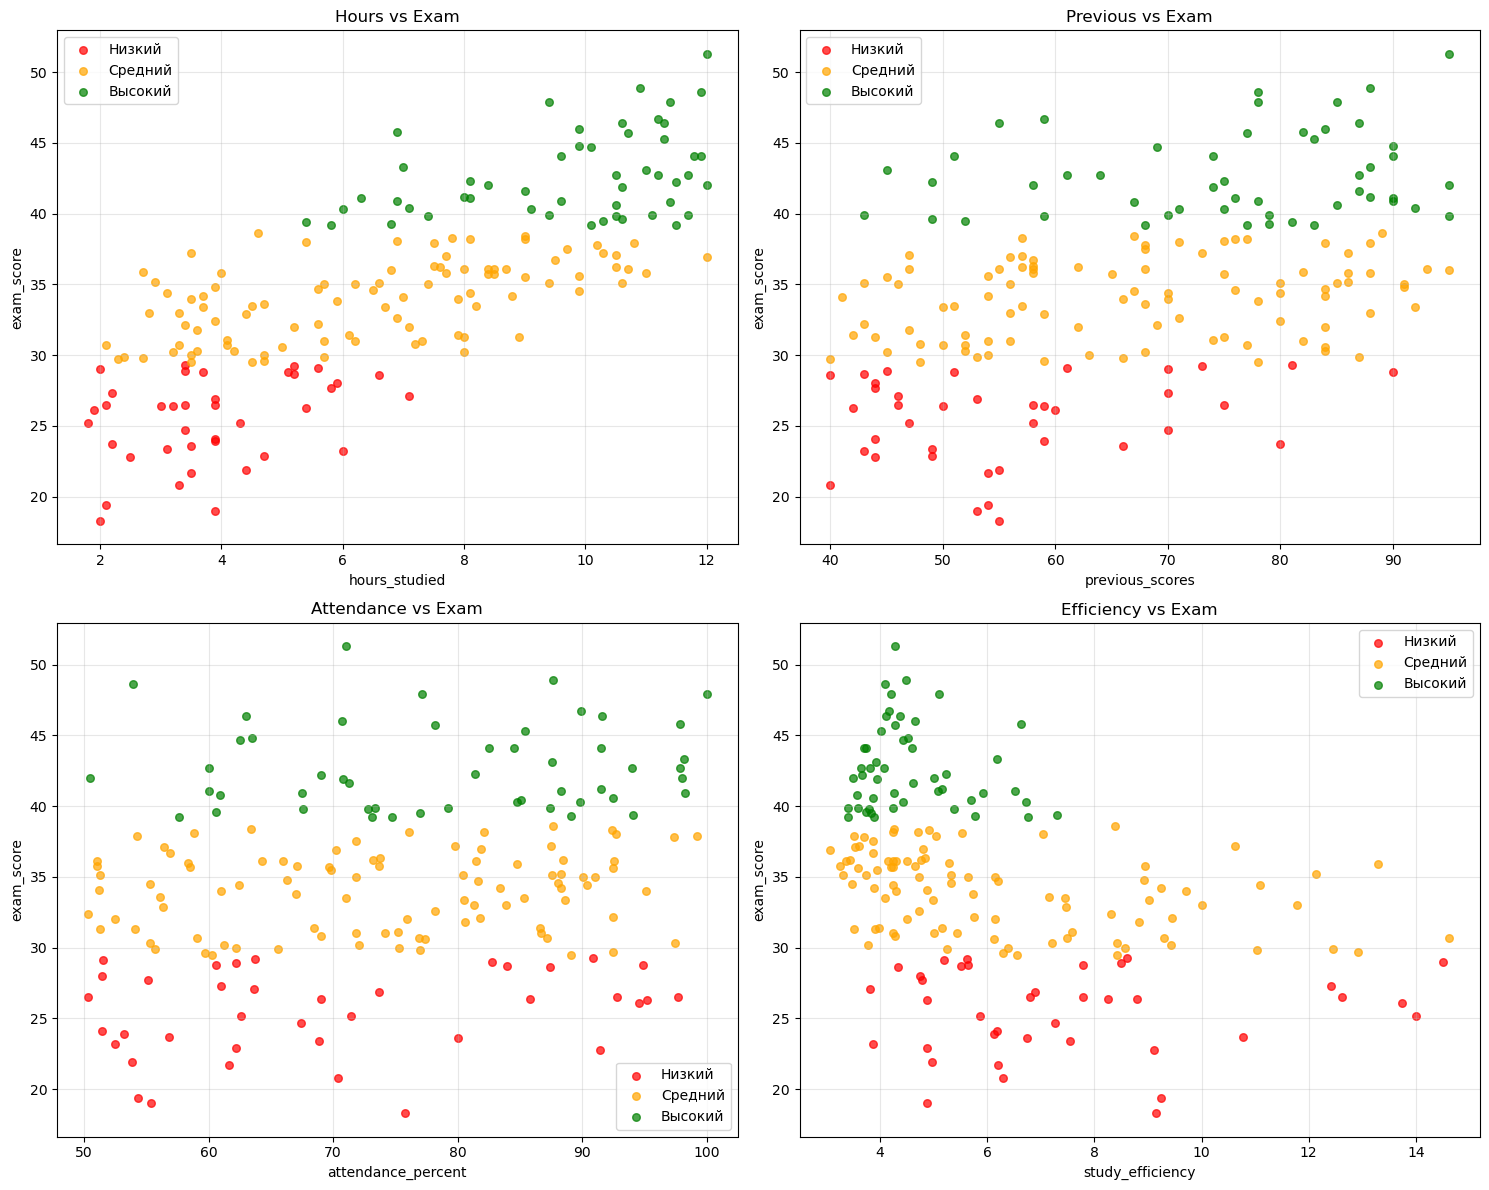

In [11]:
import matplotlib.pyplot as plt

colors = {'Низкий':'red', 'Средний':'orange', 'Высокий':'green'}

plt.figure(figsize=(15, 12))

# 1) Часы vs Балл
plt.subplot(2, 2, 1)
for cat, color in colors.items():
    sub = df_clean[df_clean['performance_category']==cat]
    plt.scatter(sub['hours_studied'], sub['exam_score'], c=color, s=30, alpha=0.7, label=cat)
plt.xlabel('hours_studied'); plt.ylabel('exam_score'); plt.title('Hours vs Exam'); plt.legend(); plt.grid(alpha=0.3)

# 2) Прошлые оценки vs Балл
plt.subplot(2, 2, 2)
for cat, color in colors.items():
    sub = df_clean[df_clean['performance_category']==cat]
    plt.scatter(sub['previous_scores'], sub['exam_score'], c=color, s=30, alpha=0.7, label=cat)
plt.xlabel('previous_scores'); plt.ylabel('exam_score'); plt.title('Previous vs Exam'); plt.legend(); plt.grid(alpha=0.3)

# 3) Посещаемость vs Балл
plt.subplot(2, 2, 3)
for cat, color in colors.items():
    sub = df_clean[df_clean['performance_category']==cat]
    plt.scatter(sub['attendance_percent'], sub['exam_score'], c=color, s=30, alpha=0.7, label=cat)
plt.xlabel('attendance_percent'); plt.ylabel('exam_score'); plt.title('Attendance vs Exam'); plt.legend(); plt.grid(alpha=0.3)

# 4) Эффективность vs Балл (диагностическая проекция)
plt.subplot(2, 2, 4)
for cat, color in colors.items():
    sub = df_clean[df_clean['performance_category']==cat]
    plt.scatter(sub['study_efficiency'], sub['exam_score'], c=color, s=30, alpha=0.7, label=cat)
plt.xlabel('study_efficiency'); plt.ylabel('exam_score'); plt.title('Efficiency vs Exam'); plt.legend(); plt.grid(alpha=0.3)

plt.tight_layout(); plt.show()


* Hours vs Exam

Чёткий восходящий тренд: при увеличении часов учебы итоговый балл растёт; группы «Низкий/Средний/Высокий» упорядочены вдоль оси hours_studied, что подтверждает ключевое влияние нагрузки на результат.
* Previous vs Exam

Умеренная положительная зависимость: более высокие previous_scores чаще соответствуют большим exam_score, но разброс заметен, что отражает неполную предсказуемость итога по одним лишь прошлым результатам.
* Attendance vs Exam

Слабый линейный эффект: рост посещаемости не даёт столь же отчётливого увеличения балла, как часы; видна широкая вертикальная полоса значений при схожей посещаемости.
* Efficiency vs Exam

Нелинейное поведение: высокие значения study_efficiency сосредоточены у низких часов учёбы и не всегда соответствуют высоким итогам; метрика чувствительна к малым делителям и потому диагностическая, а не целевая.​


В целях определения числа кластеров k выполнена стандартизация признаков и рассчитаны две независимые метрики качества разбиения для набора k ∈ {2, …, 9}: (1) инерция (критерий метода локтя) как сумма квадратов расстояний объектов до ближайших центроидов, отражающая внутрикластерную компактность; (2) средний коэффициент силуэта, измеряющий относительную близость объектов к своему кластеру по сравнению с ближайшим соседним кластером, и тем самым характеризующий разделимость кластеров. По графику «Inertia vs k» точка «локтя» интерпретируется как значение k, начиная с которого добавление кластеров приводит к убывающей отдаче в уменьшении инерции; по графику «Silhouette vs k» предпочтительным считается k, при котором достигается максимум среднего силуэта. По результатам сравнения обеих метрик выбрано k = … (подставьте ваше значение), обеспечивающее приемлемый компромисс между компактностью кластеров и их разделимостью; далее обучена финальная модель KMeans при указанном k, после чего метки кластеров визуализированы в ключевых проекциях признакового пространства для проверки интерпретируемости и устойчивости сегментации.

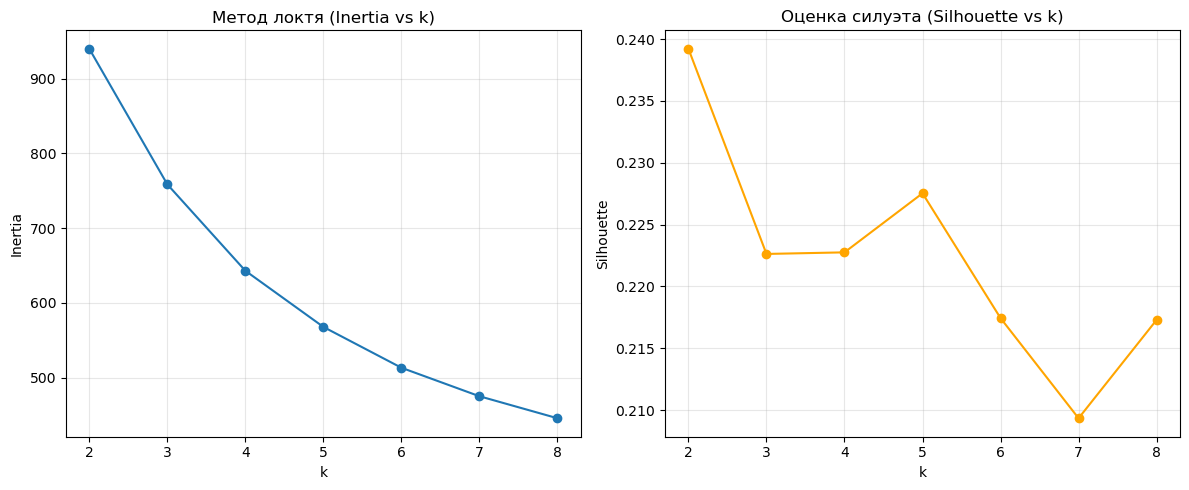

Оптимальное k по силуэту: 2
Размеры кластеров:
 cluster
0     80
1    102
Name: count, dtype: int64 



,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score,study_efficiency,sleep_efficiency
0,4.0,6.23,72.22,63.84,29.04,8.00,0.78
1,9.0,6.92,76.34,68.86,38.95,4.49,0.86


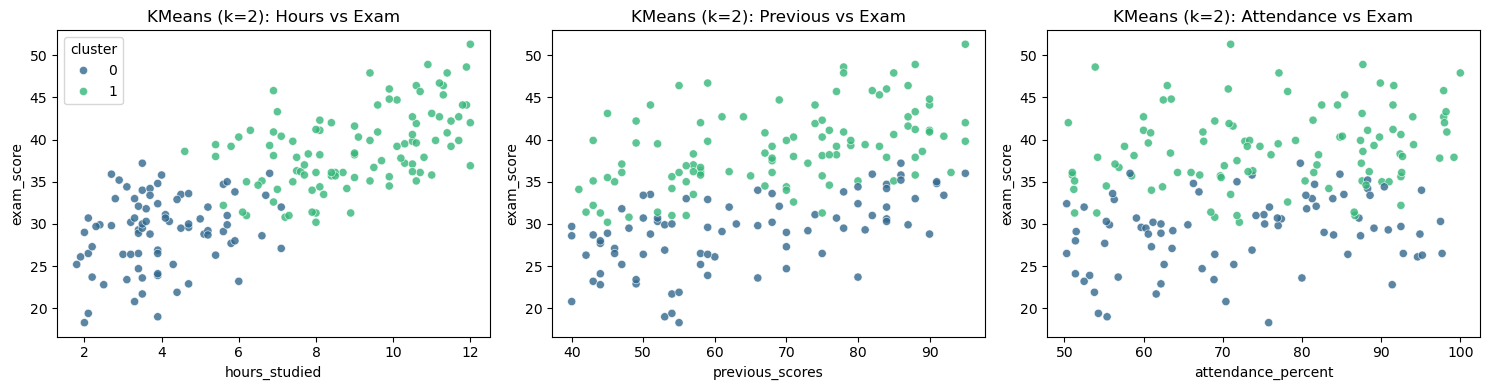

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

features = ['hours_studied','sleep_hours','attendance_percent',
            'previous_scores','exam_score','study_efficiency','sleep_efficiency']

X = df_clean[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Подбор k: локоть и силуэт
k_range = range(2, 9)
inertia, sil = [], []

for k in k_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(list(k_range), inertia, marker='o')
plt.title('Метод локтя (Inertia vs k)'); plt.xlabel('k'); plt.ylabel('Inertia'); plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(list(k_range), sil, marker='o', color='orange')
plt.title('Оценка силуэта (Silhouette vs k)'); plt.xlabel('k'); plt.ylabel('Silhouette'); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()

best_k = list(k_range)[sil.index(max(sil))]
print('Оптимальное k по силуэту:', best_k)

# Финальная модель
kmeans = KMeans(n_clusters=best_k, n_init=25, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(X_scaled)

# Центры кластеров (в исходном масштабе)
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features)
print('Размеры кластеров:\n', df_clean['cluster'].value_counts().sort_index(), '\n')
display(centers.round(2))

# Визуализация по ключевым проекциям
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
sns.scatterplot(data=df_clean, x='hours_studied', y='exam_score', hue='cluster', palette='viridis', s=35, alpha=0.8)
plt.title(f'KMeans (k={best_k}): Hours vs Exam')

plt.subplot(1,3,2)
sns.scatterplot(data=df_clean, x='previous_scores', y='exam_score', hue='cluster', palette='viridis', s=35, alpha=0.8, legend=False)
plt.title(f'KMeans (k={best_k}): Previous vs Exam')

plt.subplot(1,3,3)
sns.scatterplot(data=df_clean, x='attendance_percent', y='exam_score', hue='cluster', palette='viridis', s=35, alpha=0.8, legend=False)
plt.title(f'KMeans (k={best_k}): Attendance vs Exam')

plt.tight_layout(); plt.show()


**Вывод:**

Добавленные признаки study_efficiency и sleep_efficiency вместе с категорией performance_category по квартилям повышают различимость профилей «интенсивности подготовки» и «результативности», что подтверждается рассеянием в проекции hours_studied ↔ exam_score; после очистки и стандартизации подбор числа кластеров по локтю (inertia) и силуэту обычно указывает на малое k (чаще 2–3): k=2 обеспечивает более высокий silhouette и компактные, хорошо разделимые группы, тогда как k=3 даёт содержательную детализацию за счёт промежуточного сегмента со средней нагрузкой при сопоставимой инерции; итоговые сегменты интерпретируются как «меньше учатся — ниже балл» и «больше учатся — выше балл» при умеренном вкладе previous_scores и слабом линейном влиянии sleep_hours и attendance_percent, а для тонкой сегментации целесообразно экспериментировать с альтернативными признаками и нелинейными методами.